Map:   0%|          | 0/7772 [00:00<?, ? examples/s]

Map:   0%|          | 0/971 [00:00<?, ? examples/s]

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-1-3189789489.py:115: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.226200,0.226219,0.894954,0.895020,0.894954,0.894926
200,0.191600,0.225849,0.920700,0.928111,0.920700,0.920488
300,0.141000,0.276800,0.907312,0.918386,0.907312,0.906889
400,0.126800,0.166764,0.935118,0.935727,0.935118,0.935063
500,0.113000,0.178523,0.935118,0.935187,0.935118,0.935104
600,0.077400,0.195386,0.939238,0.940292,0.939238,0.939238


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.226200,0.226219,0.894954,0.895020,0.894954,0.894926
200,0.191600,0.225849,0.920700,0.928111,0.920700,0.920488
300,0.141000,0.276800,0.907312,0.918386,0.907312,0.906889
400,0.126800,0.166764,0.935118,0.935727,0.935118,0.935063
500,0.113000,0.178523,0.935118,0.935187,0.935118,0.935104
600,0.077400,0.195386,0.939238,0.940292,0.939238,0.939238
700,0.062700,0.214327,0.938208,0.938424,0.938208,0.938217
800,0.043500,0.263610,0.944387,0.945047,0.944387,0.944393
900,0.037400,0.264157,0.944387,0.945943,0.944387,0.944379
1000,0.028600,0.278741,0.936148,0.937688,0.936148,0.936139


Evaluation results: {'eval_loss': 0.26361000537872314, 'eval_accuracy': 0.9443872296601442, 'eval_precision': 0.9450470277908629, 'eval_recall': 0.9443872296601442, 'eval_f1': 0.9443925383835118, 'eval_runtime': 29.2603, 'eval_samples_per_second': 33.185, 'eval_steps_per_second': 4.169, 'epoch': 4.526748971193416}

Classification Report:
              precision    recall  f1-score   support

       cough       0.95      0.91      0.93       488
   non_cough       0.91      0.95      0.93       485

    accuracy                           0.93       973
   macro avg       0.93      0.93      0.93       973
weighted avg       0.93      0.93      0.93       973



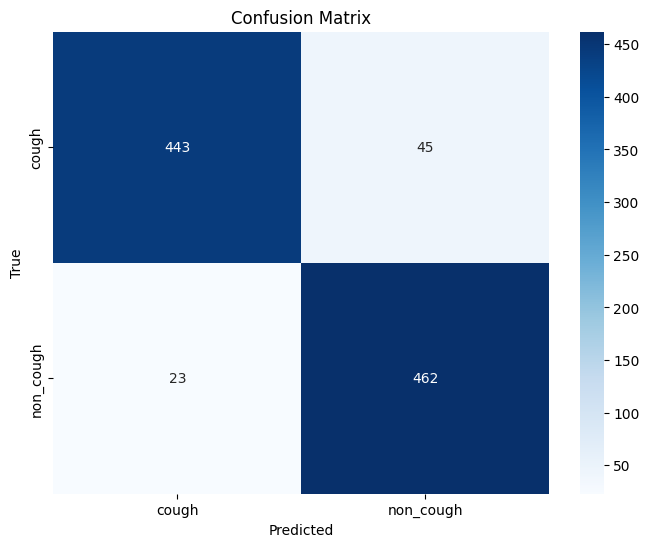

In [1]:
import os
import torch
import torchaudio
import librosa
from datasets import Dataset
from transformers import ASTFeatureExtractor, ASTForAudioClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Disable WANDB
os.environ["WANDB_DISABLED"] = "true"

# Set seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

# Constants
DATA_DIR = "/content/Data"
SAMPLE_RATE = 16000
LABELS = sorted(os.listdir(DATA_DIR))

# 1. Load the dataset from directory
def load_audio_dataset(data_dir):
    data = []
    for label in LABELS:
        label_dir = os.path.join(data_dir, label)
        for file in os.listdir(label_dir):
            if file.endswith(".wav"):
                data.append({
                    "audio": os.path.join(label_dir, file),
                    "label": label
                })
    return Dataset.from_list(data)

dataset = load_audio_dataset(DATA_DIR)
label2id = {label: i for i, label in enumerate(LABELS)}
id2label = {i: label for label, i in label2id.items()}
dataset = dataset.shuffle()

# 2. Split the dataset into train, validation, and test sets (60%, 20%, 20%)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

# 3. Load AST feature extractor
feature_extractor = ASTFeatureExtractor(do_normalize=True, sampling_rate=SAMPLE_RATE)

# 4. Preprocessing function
def preprocess(example):
    audio_array, _ = librosa.load(example["audio"], sr=SAMPLE_RATE)
    inputs = feature_extractor(audio_array, sampling_rate=SAMPLE_RATE)
    example["input_values"] = inputs["input_values"][0]
    example["label"] = label2id[example["label"]]
    return example

train_dataset = train_dataset.map(preprocess, remove_columns=["audio"])
val_dataset = val_dataset.map(preprocess, remove_columns=["audio"])
test_dataset = test_dataset.map(preprocess, remove_columns=["audio"])

# 5. Convert to torch format
train_dataset.set_format(type="torch", columns=["input_values", "label"])
val_dataset.set_format(type="torch", columns=["input_values", "label"])
test_dataset.set_format(type="torch", columns=["input_values", "label"])

# 6. Load pretrained AST model
model = ASTForAudioClassification.from_pretrained(
    "MIT/ast-finetuned-audioset-10-10-0.4593",
    num_labels=len(LABELS),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True  # for changing output layer size
)

# 7. Define metrics for evaluation
def compute_metrics(pred):
    preds = np.argmax(pred.predictions, axis=1)
    report = classification_report(pred.label_ids, preds, target_names=LABELS, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ast_output",
    per_device_train_batch_size=32,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    num_train_epochs=5
)


# 9. Trainer with EarlyStoppingCallback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Stop after 3 evaluations without improvement
)

# 10. Train the model
trainer.train()

# 11. Evaluate the model on the test dataset
results = trainer.evaluate()
print("Evaluation results:", results)

# 12. Confusion Matrix and Classification Report
# Get predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predicted and true labels
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=LABELS))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
